## 1. 들어가며  
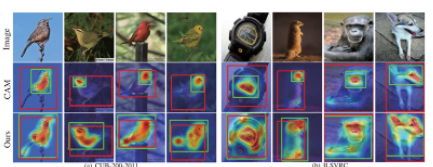  
CAM(Class Activation Map)을 얻기 위한 방법 중  
-> 기본 CAM과 Grad-CAM 구현 + 시각화  
-> CAM을 활용해서 물체의 위치를 찾는 object detection 수행  
-> 정답 데이터와 비교  

#### 실습목표
- Classification model로부터 CAM을 얻어낼 수 있다.
- CAM으로 물체의 위치를 찾을 수 있다.
- CAM을 시각화 비교할 수 있다.

#### 학습 내용
- CAM, Grad-CAM용 모델 준비하기
- CAM
- Grad-CAM
- Detection with CAM
----

In [1]:
# 프로젝트 위한 디렉토리 생성
!  mkdir -p ~/aiffel/class_activation_map

## 2. CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기  

#### 1. CAM(Class Activation Map)  
- CAM = 클래스에 대한 활성화 정도를 나타낸 지도  
  기본적으로 우리 모델은 분류(classfication)를 수행하는 모델   


- CAM 구조  
  특성을 추출하는 CNN 네트워크 뒤에  
  +GAP(Global Average Pooling) +소프트맥스 레이어(softmax layer) 붙는 형태  
  <- 반면 Grad-CAM은 이러한 제약 없음  


- CAM과 Grad-CAM 두가지 모두 구현해볼 예정  
  1) CAM 모델 먼저 구성해 기본적인 CAM 추출  
  2) 모델에서 Grad-CAM을 활용해 다시 시각화 결과물 추출  
  -> 최종 목표는 이미지 내 클래스 활성화 된 위치 확인하고  
  이를 정답과 비교하는 것이라 위치 정보가 기록된 데이터가 함께 있어야 함  
  
  
- 위치 정보 기록된 데이터  
  -> Tensorflow Datasets의 카탈로그에서 확인 가능  
  -> 해당 프로젝트에서 사용할 데이터셋 : stanford_dogs 데이터 셋  
  -> 120 종의 개를 사진으로 판별하는 분류 문제 데이터셋  
  라벨이 위치 정보인 바운딩 박스(bounding box) 정보 포함  
  [stanford_dogs in Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/stanford_dogs)  

##### 0) 필요 라이브러리 준비  

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### 1) 데이터 셋 다운로드 
- stanford_dogs 데이터셋  
  학습용 데이터 : 12000 장  
  평가용 데이터 : 8580 장  
  
  
- tfds.load() : 데이터셋 다운  

In [3]:
#데이터셋 다운로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

##### 2) 각 이미지 클래스, 인덱스 확인  
- tfds.show_examples() : class, index 확인  
- 학습용 데이터 셋 시각화

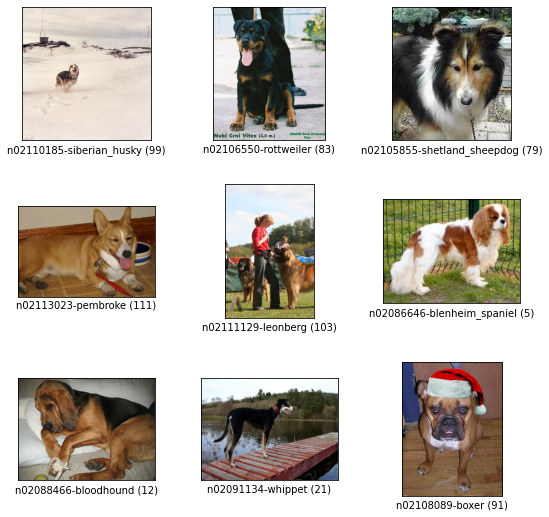

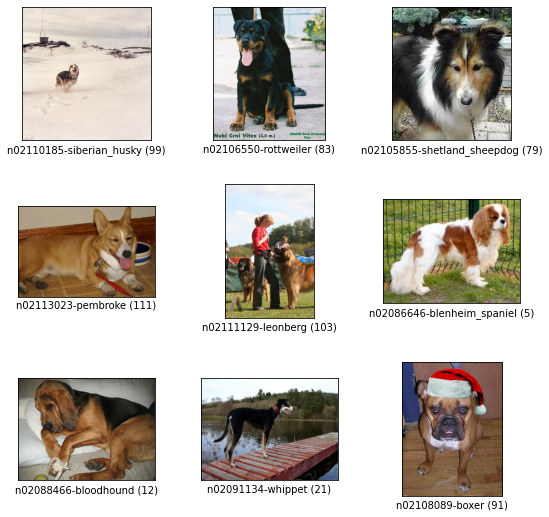

In [4]:
tfds.show_examples(ds_train, ds_info)

- 학습용 평가용 데이터 셋 시각화

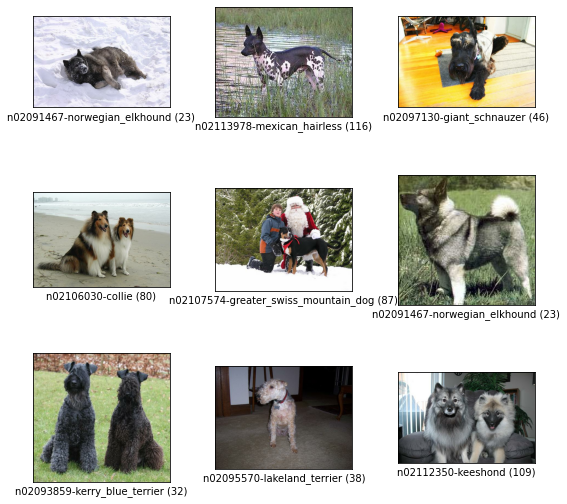

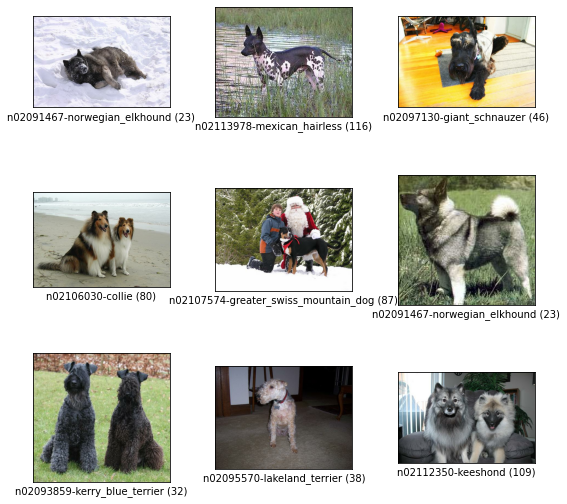

In [5]:
tfds.show_examples(ds_test, ds_info)

## 3. CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보  

#### 1. feature 확인하기  
- 원본 이미지 위에 물체 위치정보 어떻게 시각화?  
  -> 우선 데이터셋 메타 정보 df_info 조회  
  -> features가 어떻게 구성되어 있는지 확인  

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

- image : 입력이미지  
- label : 이미지에 해당하는 정답 클래스의 인덱스  
- bbox =바운딩박스 : 물체의 위치를 사각형 영역으로 표기하는 방법  
  -> BBoxFeature 타입으로 정의되어 있는 것 위에서 확인 가능  
  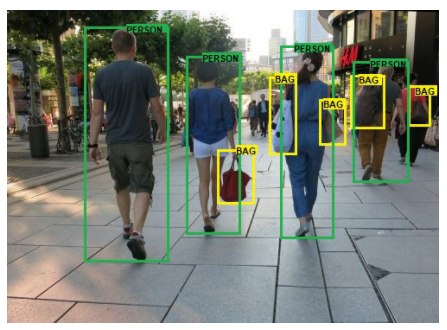  

#### 2. 바운딩 박스를 표시하는 방법들  

##### 1) xywh  
- 바운딩박스 중심점을 x,y 표기  
- 사각형 너비 w, 높이 h를 표기  
- 예시 : (x_center, y_center, width, height)  
  -> x,y가 중심점이 아니라 좌측 상단 점 가리킬 수도 있음  
  
  
##### 2) minmax  
- 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법  
- 예시 : (x_min, x_max, y_min, y_max)  
- 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로  
  normalize한 상대적인 값을 표기하는 것이 일반적  
  
-> 이외 이미지의 상하좌우 끝단으로부터 거리로 표현하는 방법,  
   LRTB = 좌우측의 x값, 상하측의 y값 네개로 표시하는 방법,  
   QUAD = 네 점의 x,y 좌표 값 모두 표시하는 방법 등  
   <- 새로운 데이터셋 접하거나 라이브러리 활용할 때  
   간단한 바운딩 박스 정보라도 한번 더 표기법 확인할 것  


##### 3) [BBoxFeature_텐서플로우 튜토리얼](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature)  
- BBoxFeature 타입으로 표기된 bbox 필드는 어떤 방식으로 바운딩 박스를 라벨링 하고 있지?  
  -> 해당 bounding box는 minmax 의미  
  -> tfds의 경우 height를 첫번째 axis로 삼고있어 [ymin, xmin, ymax, xmax]를 의미  

-----
## 4. CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기  

##### 1) CAM 얻기 위한 모델 생성  
- 이미지넷(ImageNet) 데이터에 훈련된 ResNet50을 기반  

- pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델 생성  
  (소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어)  
  
- CAM 모델은 우리가 해왔던 분류 문제를 위한 모델과 크게 다른 점 없음  
  대신! 마지막 fully connected layer 대신 GAP 사용  
  -> ResNet50의 매개변수 pooling에 'avg'를 매개변수로 전달함으로써 쉽게 GAP 연산
  
  
- [tf.keras.applications.resnet50.ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50)

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

##### 2) 만든 CAM 모델 확인

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

- CAM은 특성 맵(feature map) 사용해서 만듦  
  사용하는 특성 맵 어떤 레이어 출력 값일까?  
  -> conv5_block3_out의 output이 feature map  
  -> 이 feature map에 Global average pooling을 하여 feature의 크기 줄임  
  -> 줄어든 feature 전체에 Dense layer 붙여서  classification 수행  

## 5. CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기  

##### 1) 데이터 전처리
- normalize_and_resize_img() : normalizing과 resizing을 포함한 간단한 전처리  
- apply_normalize_on_dataset() : 배치구성  


- input에 이전과 달리 bbox 정보가 포함  
  -> 그러나 현재 CAM 모델의 학습에는 필요 없음  
  -> 그래서 normalize_and_resize_img 과정에서 제외  
  <- CAM이 object detection이나 segmentation에도 활용 가능  
  -> 그러나 bounding box 같은 직접적인 라벨을 사용하지 않고  
  weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문  

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양 확인 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


##### 2) 모델 compile & 학습  
- 위에서 생성한 모델 학습  
  (시간 꽤 걸림)  

In [11]:
#모델 compile
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [13]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 329s 435ms/step - loss: 0.0528 - accuracy: 0.9942 - val_loss: 0.9825 - val_accuracy: 0.7271
Epoch 2/15
750/750 [==============================] - 323s 430ms/step - loss: 0.0190 - accuracy: 0.9990 - val_loss: 0.9407 - val_accuracy: 0.7386
Epoch 3/15
750/750 [==============================] - 323s 430ms/step - loss: 0.0105 - accuracy: 0.9998 - val_loss: 0.9534 - val_accuracy: 0.7418
Epoch 4/15
750/750 [==============================] - 323s 431ms/step - loss: 0.0080 - accuracy: 0.9999 - val_loss: 0.9487 - val_accuracy: 0.7436
Epoch 5/15
750/750 [==============================] - 323s 430ms/step - loss: 0.0069 - accuracy: 0.9999 - val_loss: 0.9469 - val_accuracy: 0.7454
Epoch 6/15
750/750 [==============================] - 322s 430ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.9604 - val_accuracy: 0.7432
Epoch 7/15
750/750 [==============================] - 325s 433ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.9556 -

##### 3) 학습 가중치 저장

In [14]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


## 6. CAM  

##### 1) restart, 다시 라이브러리 import 및 이전 스텝 코드 실행  
- 학습한 모델 활용하여 CAM 생성  
  <- 메모리 부족인해 이후 실습에 문제 발생할 수 있음  
  그래서 아래 진행 전에, 커널 재시작 권장  

In [15]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 진행  
  -> get_one() : 데이터셋에서 한 장씩 뽑을 수 있도록

In [16]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

100


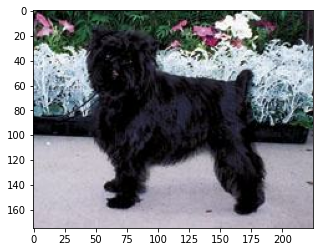

In [55]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

##### 2) 학습한 모델 불러오기   
- 데이터 준비 완료 되었으니 CAM 생성하기 위해 학습한 모델 불러오기  

In [56]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

##### 3)  CAM 생성&시각화  

- CAM을 생성하기 위해서는  
  (1) 특성 맵  
  (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치  
  (3) 원하는 클래스의 출력값이 필요  
  
  
- CAM 시각화  
  이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하기 위해  
  네트워크에서 나온 CAM을 입력이미지 사이즈와 같게 만들어서  
  함께 시각화 해야함  
  -> 이를 고려해 model, item을 받았을 때  
  입력 이미지와 동일한 크기의 CAM을 반환하는 함수 생성  
  
  
- generate_cam()  
  conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의  
  -> feedforward를 거친 후  
  -> CAM 계산하도록 구현  
  -> 입력 이미지 크기에 맞춰 CAM resize 해줌  

In [57]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

- 위 함수 이용해서 CAM 얻기  
  생각보다 위치 정확하게 표현됨  

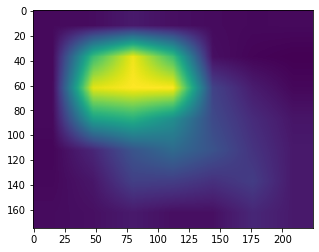

In [58]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

- 위 같이 그려진 CAM 이미지 + 원본 이미지 합치기  

In [59]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

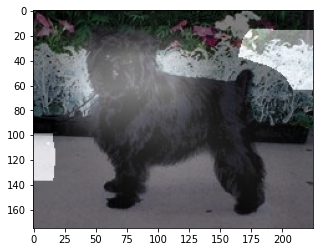

In [60]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

- 생성된 CAM이 개를 식별하는데 중요한 이미지 부분 잘 포착되고 있는가?  
  -> 주로 강아지의 얼굴, 몸통 있는 부분이 강조되는 경향 있음  
  -> 사람이 개를 식별할 때 유의해서 보는 부분과 일맥상통  

## 7. Grad-CAM  
- Grad-CAM은 적용 모델을 유연하게 선택할 수 있는 특징이 있음  
 -> 위에서 만들었던 모델 다시 활용해도 괜찮음  
 -> 관찰 대상 모델은 cam_model 그대로 활용  
 
##### 1) 새로운 이미지 뽑아보기  

40


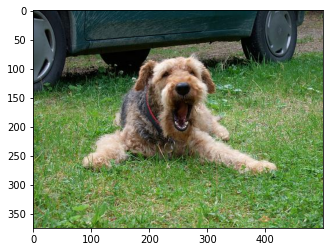

In [71]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

##### 2)  Grad-CAM 이용 -> CAM 만들기 & 시각화
- grad_cam  
  관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고  
  -> 여기에 GAP 연산을 적용  
  -> 관찰 대상이 되는 레이어의 채널별 가중치 구함   
  -> 최종 CAM 이미지를 구하기 위해  
  레이어의 채널별 가중치(weights), 레이어에서 나온 채널별 특성 맵을  
  가중합해주어 cam_image 얻음  
  
  
- 이전 스텝의 CAM 함수와 달리,  
  Grad-CAM은 어떤 레이어든 CAM 이미지 뽑아낼 수 있음  
  -> 그레디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록  
  activation_layer의 이름을 받고 이를 활용해야 함  
  
  
- generate_grad_cam()  
  원하는 레이어의 ouput과  
  특정 클래스의 예측값(prediction) 사이의 그래디언트  
  = grad_val을 얻고  
  -> 이를 가중치 (weights)로 활용  

In [72]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


- 위 함수로 레이어의 CAM 이미지 뽑아내기  
- 각 레이어에서 생성되는 CAM 생성  
  레이어 이름은 스텝 10-4의 cam_model.summary()에서 찾을 수 있음  

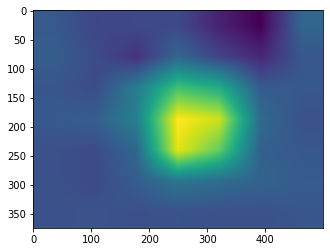

In [73]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

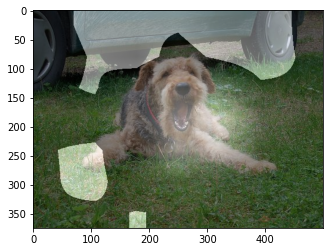

In [74]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

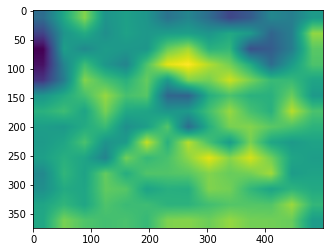

In [75]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

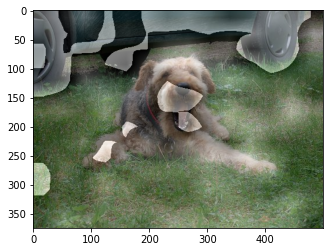

In [76]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

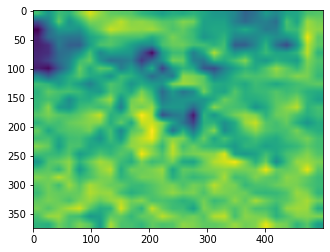

In [77]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

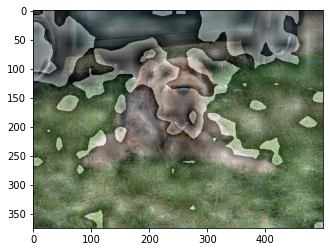

In [78]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

## 8. Detection with CAM  

#### 1. 바운딩 박스  
- CAM에서 물체의 위치를 찾는 detection  

##### 1) 새로운  CAM/ Grad-CAM 이미지 뽑아보기
- generate_cam() 활용해서 CAM 이미지 뽑음  

108


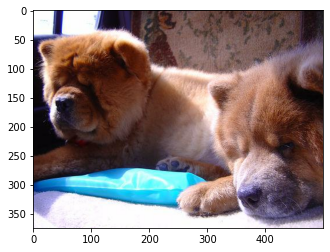

In [166]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

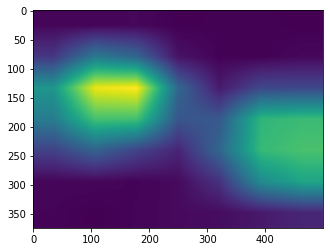

In [167]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

- generate_grad_cam() 활용해서 Grad-CAM 이미지 뽑음 

##### 2) 바운딩 박스 얻기  
- get_bbox() :  
  바운딩 박스를 만들기 위해서 score_thresh를 받아  
  역치값 이하의 바운딩 박스는 없앰  
  -> 그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형 찾기  
  -> 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있음  
  -> boxPoints()로 이를 꼭지점으로 바꾸어 줌  
  -> 마지막에는 int 자료형으로 변환  

In [168]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

##### 3) 바운딩 박스 시각화  
- CAM  
  cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화한 모습을 볼 수 있음  

In [169]:
rect = get_bbox(cam_image)
rect

array([[-46, 299],
       [  7,   1],
       [548,  98],
       [494, 396]])

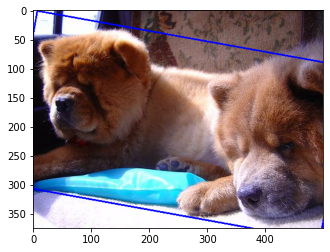

In [170]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

- Grad-CAM  
  grad_cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화한 모습을 볼 수 있음

In [171]:
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[111, 345],
       [111,  77],
       [452,  77],
       [452, 345]])

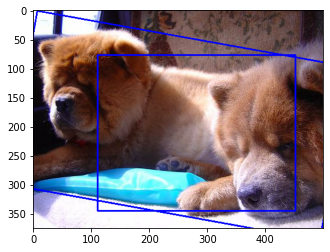

In [172]:
grad_image = copy.deepcopy(item['image'])
grad_image = cv2.drawContours(image, [grad_rect], 0, (0,0,255), 2)
plt.imshow(grad_image)
plt.show()

#### 2. Intersection Over Union  
- 위에서 CAM과 Grad-CAM 두 가지 방법을 통해서 바운딩 박스를 얻을 수 있었음  
  -> 그럼 정답 데이터인 바운딩 박스와 이를 어떻게 비교, 평가할까?  
  -> IoU(Intersection over Union)  
     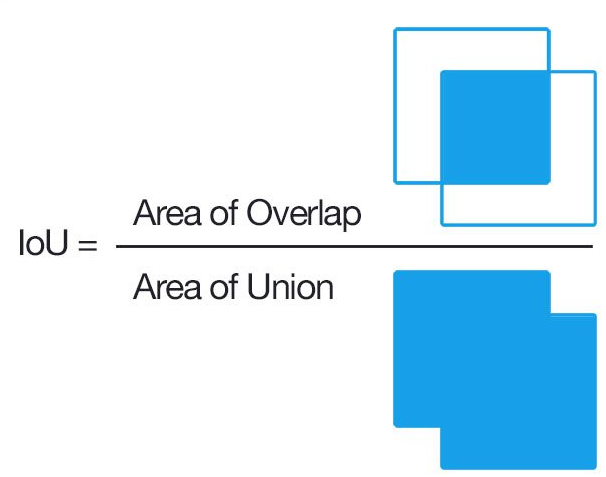  
     두 영역의 교집합인 intersection 영역의 넓이를  
     두 영역의 합집합인 union 영역으로 나누어준 값  
  -> 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이  
  영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있음  
  -> 즉, 모델이 영역 잘 찾았는지 비교하는 좋은 지표가 됨  
  [더 자세한 영상: C4W3L06 Intersection Over Union](https://www.youtube.com/watch?v=ANIzQ5G-XPE)  
  

##### 1) rect(바운딩박스 좌표) 구하는 함수 생성  

In [173]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

##### 2) 위에서 구했던 rect 를 minmax bbox 형태로 치환  
- CAM

In [174]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0026666666666666666, -0.092, 1.056, 1.096]

- Grad-CAM

In [175]:
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.20533333333333334, 0.222, 0.92, 0.904]

##### 3) 해당 데이터의 ground truth bbox를 확인

In [176]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

##### 4) IoU 계산 : 얼마나 유사한지  
- CAM/ Grad-CAM의 추론 결과로 얻어진 bbox가  
  ground truth bbox와 얼마나 비슷한지 평가  
  
##### 4-1) IoU 계산 함수 생성  

In [177]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

##### 4-2) CAM IoU

In [178]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.340173876189527

##### 4-3) Grad-CAM IoU

In [179]:
get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.48280342430017964

##### 5) IoU평가  
- CAM 보다 Grad-CAM IoU값이 더 높다  
  IoU는 상대적인 비율로 정확도를 나타내기 때문에  
  값이 더 높은 Grad-CAM이 더 성능이 좋다고 판단할 수 있음  


## 회고  

#### 💚루브릭  
##### 1) CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?  
- ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴  

##### 2) 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?  
- CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어짐  
- 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영함  

##### 3) 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?  
- CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해  
  CAM과 Grad-CAM의 object localization 성능이 비교분석 됨  
  
  
#### 💚 회고록  
##### 1) CAM, Grad-CAM 개념  
- [CAM, Grad-CAM 개념](https://github.com/ga0808/GoingDeeper_CV/tree/main/%5BCV-5%5D%20CAM,%20Grad-CAM,%20ACoL)  
  -> 이번 프로젝트와 관련된 선행 학습내용  

- [CAM 논문 리뷰](https://jays0606.tistory.com/4)
- [Grad-CAM 논문 리뷰](https://velog.io/@tobigs_xai/CAM-Grad-CAM-Grad-CAMpp)
- [Grad-CAM 세미나 자료](file:///C:/Users/82103/Downloads/Grad_CAM_191205_%EB%B0%B1%EC%9D%B8%EC%84%B1_%EC%A0%84%EB%8B%AC%EC%9A%A9.pdf)  
  [위 자료 리뷰](http://dmqm.korea.ac.kr/activity/seminar/274)  
- [CAM, Grad-CAM 설명_블로그](https://tyami.github.io/deep%20learning/CNN-visualization-Grad-CAM/)

##### 2) 바운딩박스  
- EX-3 고양이수염 붙일 때 바운딩 박스 좌표에 대해서  
  공부하는 것이 어려웠었는데  
  이번 프로젝트를 진행하면서 보다 쉽게 이해할 수 있었다  

##### 3) CAM, Grad-CAM 차이 정리  
##### 3-1)  
- CAM은 Image Classification 문제에 대해 높은 예측성능을 보이지만,  
  그것에 대한 원인을 파악하기 힘든 문제 상황에서  
  이를 Global Average Pooling(GAP)를 이용해 해결한 방법론  
  -> 하지만 CAM을 적용하기 위해서는 마지막 히든 레이어의 형태가 Fully Connected 여야 한다는 가정이 있었다  
  
  
- Gram-CAM은 마지막 히든 레이어 형태에 관계 없이 적용할 수 있도록  
  Feature map을 flatten 하여 예측 모델의 원인을 탐지하게 한 방법론  

##### 3-2)  
- 딥러닝 분야에서는 예측 및 분류를 진행할 때, 결과에 대한 해석을 하는 것이 쉽지 않았다.  


- CAM은 결과에 대한 원인 분석 및 해석을 진행하기 위해 적용하는 기법으로 널리 사용되고 있다.  
  CAM은 Convolution layer를 통과 후 마지막 Feature map에서 Global average pooling (GAP)을 적용해  
  예측 및 분류 결과에 대한 원인 분석 및 해석을 진행한다.  


- Grad_CAM은 CAM과 달리 마지막 Feature map에 GAP를 적용하지 않고  
  바로 각 Feature map의 pixel 개수에 대한 노드와 완전 연결 구조를 이루어 진행한다  
  이렇게 연결된 구조에 가중치를 가지고 결과에 대한 원인 분석을 하게 된다.  
  따라서 이미지의 각 pixel별로 원인 분석이 가능하게 되며 CAM보다 더욱 세밀하고 자세한 해석이 가능하게 된다. 
  
  
##### 4) IoU 추가 공부  
- Intersection over Union (IoU)는 object detection에서 사용되는 도구다  
- 성능 지표는 아니고, 객체 인식 모델의 성능 평가를 하는 과정에서 사용되는 도구로 생각하면 된다  
- 실제 객체 위치 바운딩 박스 = ground trurh와  
  예측한 바운딩 박스 =prediction 두 박스가  
  중복되는 영역의 크기를 통해 평가하는 방식  
  = 즉, 겹치는 영역이 넓을 수록 잘 예측한 것으로 평가  
  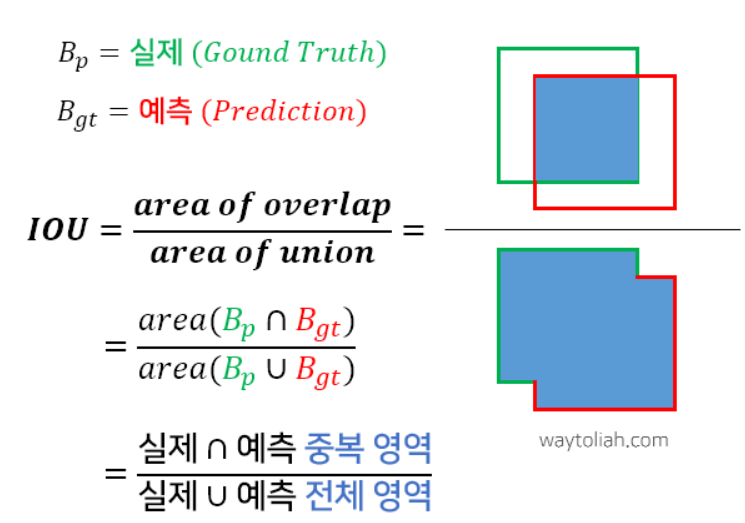
- [참고 블로그_1](https://ballentain.tistory.com/12)  
- [참고블로그_2](https://www.waytoliah.com/1491)

##### 5) IoU외 object detection 성능 평가 지표  
- Precision& Recall = 정밀도, 재현율
- Precision& Recall Curve = 정밀도-재현율 곡선  
- AP = Average Precision = 평균 정밀도  
- mAP = mean Average Performance  
- [위 지표내용 설명_블로그](https://www.waytoliah.com/1491)